<a href="https://colab.research.google.com/github/EzerzerDavid/Assignment1/blob/main/MLAssignmentDavidEzerzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


https://github.com/EzerzerDavid/Assignment1.git



In [10]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.7 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 81.9+ KB


None

EDA is conducted to identify missing values, detect potential anomalies, and understand data distributions. Identifying missing values helps in choosing the best imputation strategy.


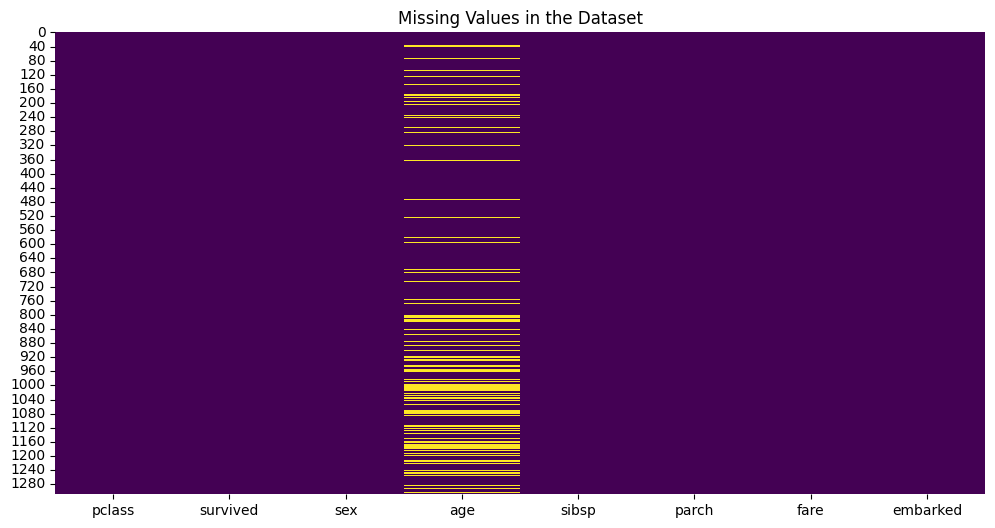

We use median imputation for 'age' because the median is less sensitive to extreme outliers, unlike the mean, which can be significantly skewed by a few high or low values.
For 'fare', median imputation is also used as fares might have extreme values, making the median a more robust choice.
For 'embarked', mode imputation is chosen as it is a categorical variable and replacing missing values with the most common category ensures consistency.
Target encoding is applied to 'embarked' as it captures the relationship between categorical variables and the target variable, reducing dimensionality compared to OneHotEncoding.
Standardization (StandardScaler) is applied to 'age' and 'fare' to ensure zero mean and unit variance, making the features more suitable for models like Logistic Regression.
MinMaxScaler is also applied as an alternative to scale values between 0 and 1, which is useful when working with models that do not assume a standard normal distribution.
Instead of SMOTE, class weig

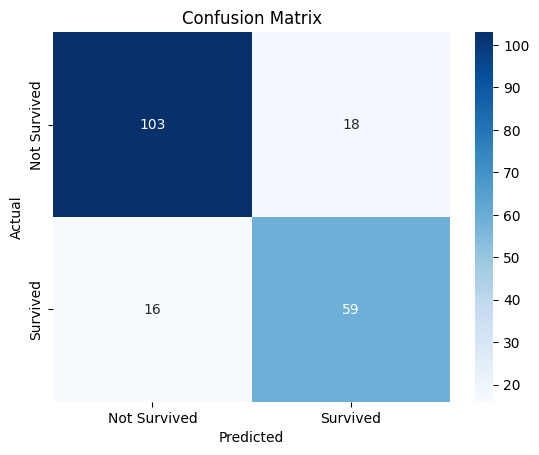


The ROC (Receiver Operating Characteristic) curve illustrates the trade-off between True Positive Rate (Sensitivity) and False Positive Rate. The AUC (Area Under the Curve) is a summary measure of the model’s ability to distinguish between classes.


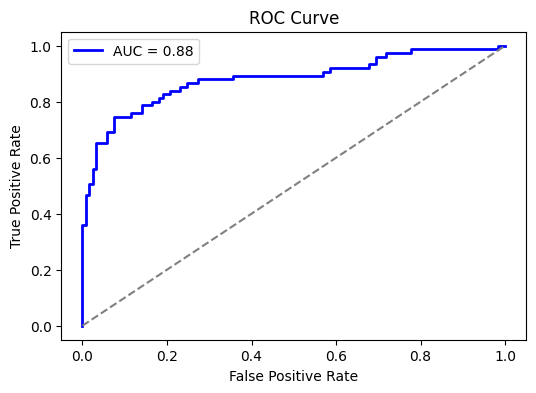

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE, ADASYN
from category_encoders import TargetEncoder
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define file path in Google Drive
file_path = "/content/drive/My Drive/titanic3.xls"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset not found: {file_path}. Please ensure the file is uploaded to Google Drive.")

df = pd.read_excel(file_path)

# Drop non-numeric and non-relevant columns
df.drop(columns=['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest'], inplace=True, errors='ignore')

# Display basic information
display(df.head())
display(df.info())

# Explanation: Exploratory Data Analysis (EDA)
print("EDA is conducted to identify missing values, detect potential anomalies, and understand data distributions. Identifying missing values helps in choosing the best imputation strategy.")

def visualize_missing_values(df):
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values in the Dataset")
    plt.show()

visualize_missing_values(df)

# Handling Missing Values
print("We use median imputation for 'age' because the median is less sensitive to extreme outliers, unlike the mean, which can be significantly skewed by a few high or low values.")
df['age'] = df['age'].fillna(df['age'].median())
print("For 'fare', median imputation is also used as fares might have extreme values, making the median a more robust choice.")
df['fare'] = df['fare'].fillna(df['fare'].median())
print("For 'embarked', mode imputation is chosen as it is a categorical variable and replacing missing values with the most common category ensures consistency.")
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

# Encoding Categorical Variables using Target Encoding
print("Target encoding is applied to 'embarked' as it captures the relationship between categorical variables and the target variable, reducing dimensionality compared to OneHotEncoding.")
encoder = TargetEncoder()
df['embarked'] = encoder.fit_transform(df['embarked'], df['survived'])

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_cols = ['sex']
ohe_data = pd.DataFrame(ohe.fit_transform(df[categorical_cols]))
ohe_data.columns = ohe.get_feature_names_out(categorical_cols)
df = df.drop(columns=categorical_cols).join(ohe_data)

# Feature Scaling
print("Standardization (StandardScaler) is applied to 'age' and 'fare' to ensure zero mean and unit variance, making the features more suitable for models like Logistic Regression.")
scaler = StandardScaler()
df[['age', 'fare']] = scaler.fit_transform(df[['age', 'fare']])

print("MinMaxScaler is also applied as an alternative to scale values between 0 and 1, which is useful when working with models that do not assume a standard normal distribution.")
minmax_scaler = MinMaxScaler()
df[['age_scaled', 'fare_scaled']] = minmax_scaler.fit_transform(df[['age', 'fare']])

# Splitting Data
X = df.drop(columns=['survived'])
y = df['survived']
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, stratify=y_other, random_state=42)

# Addressing Class Imbalance using Class Weights Instead of SMOTE
print("Instead of SMOTE, class weights are used to handle imbalance by adjusting the impact of the minority class in Logistic Regression.")
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
preds = model.predict(X_val)

# Improved Output Formatting
print(f"Validation Accuracy: {accuracy_score(y_val, preds):.4f}")
print("\nClassification Report:\n", classification_report(y_val, preds, digits=4))

# Confusion Matrix Visualization
print("A confusion matrix provides insight into classification errors by showing the distribution of correct and incorrect predictions across classes.")
cm = confusion_matrix(y_val, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
print("\nThe ROC (Receiver Operating Characteristic) curve illustrates the trade-off between True Positive Rate (Sensitivity) and False Positive Rate. The AUC (Area Under the Curve) is a summary measure of the model’s ability to distinguish between classes.")
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

